# SAM: Segment Anything Model
#### The following code is an attempt at training SAM to perform accurate segmentation of chest x-rays, focusing on identifying pneumonia

## Step 1: Library Imports

In [1]:
print("Starting script...")

import os 
import cv2 #OpenCV library for iamge processing
import gc #garbage collection module
import torch #library for deep learnign
import torch.nn as nn #neural network modules from pytorch
import numpy as np
import pandas as pd
from torchvision import transforms #image transformation from torchvision
from PIL import Image #image handling
from segment_anything import sam_model_registry #model registry for different architectures 
from segment_anything import SamAutomaticMaskGenerator 
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader #for defining datasets
import pydicom
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

print("Imports completed.")

Starting script...
Imports completed.


## Step 2: Package Installation
* Installing the SAM framework from GitHub
* Supervision package for dataset handling, model training, etc
* Installing pre trained weights for VIT-B model

#### SAM Framework

In [2]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2e0bgvyu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2e0bgvyu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


#### Supervision Package

In [3]:
!pip install -q supervision

#### vit-b (vision transformer)

In [6]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2024-06-25 06:05:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.128, 13.35.7.50, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: 'sam_vit_b_01ec64.pth'

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   124MB/s    in 2.9s    

2024-06-25 06:05:27 (124 MB/s) - 'sam_vit_b_01ec64.pth' saved [375042383/375042383]



#### Ensuring the GPU acceleraton is available

In [7]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached GPU memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

CUDA available: True
CUDA version: 12.1
Total GPU memory: 17.07 GB
Allocated GPU memory: 0.00 GB
Cached GPU memory: 0.00 GB


## Step 3: Loading and Initializing SAM Model for Segmentation
* Loading model allows us to utilize the model's knowledge without training from scratch
* normally use GPU in deep learning tasks as they speed up computation, hence fast model training
* weights help improve model performance, capture patterns from training data
* generator generates segmentation masks
* predictor generates outputs based on model input data (predicts..)

In [8]:
#First Initalize
model_type = 'vit_b' #define type of model
weights_path = 'sam_vit_b_01ec64.pth' #define file path for weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #ensure GPU acceleration (CUDA) is avail 

print("Loading SAM model...")
try:
    # Load SAM model
    sam = sam_model_registry[model_type](checkpoint=weights_path) #loads model using weights file
    sam.load_state_dict(torch.load(weights_path, map_location='cuda:0')) #load weights into SAM model
    sam = sam.to(device) #move SAM model to either CPU or gPU dependign on availability
    sam.eval() 
    print(f"Loaded {model_type} model with weights from {weights_path}!!!!!.")
except Exception as e:
    print(f"error, cant load model :/: {e}")

print("initialize mask generator and predictor...")
try:
    mask_generator = SamAutomaticMaskGenerator(sam) #initialize generator
    predictor = SamPredictor(sam) #initialize predictor
    print("initialized mask generator and predictor!!!!")
except Exception as e:
    print(f"Cant initialize mask generator/predictor: {e}")

Loading SAM model...
Loaded vit_b model with weights from sam_vit_b_01ec64.pth!!!!!.
initialize mask generator and predictor...
initialized mask generator and predictor!!!!


#### checking...

In [9]:
print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached GPU memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Total GPU memory: 17.07 GB
Allocated GPU memory: 0.38 GB
Cached GPU memory: 0.43 GB


## Step 4: Setting Up Environment to Train Model

In [11]:
print("Creating Custom Dataset...")


class RSNADataset(Dataset):

    #initializes dataset attr. and transformations
    def __init__(self, csv_file, image_dir, transform=None):
        self.annotations = pd.read_csv(csv_file) #reads csv file using pandas and stores
        self.image_dir = image_dir #stores directory path
        self.transform = transform #assigns transformation pipeline
        self.image_paths = self.annotations['patientId'].unique().tolist() #grabs patient IDs from annotations and converts into image paths to represent images associated with each patient
        
        #transformation pipeline for maks, resives masks, and converts into tensor in order to fit vit-b criteria
        self.mask_transform = transforms.Compose([
            transforms.Resize((1024, 1024), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
        ])

    #returns length of dataset
    def __len__(self):
        return len(self.image_paths)

    #returns image and corresponding mask
    def __getitem__(self, idx):
        img_name = self.image_paths[idx] #retrieves image path of index from list of image paths
        
        try:
            dicom_file = os.path.join(self.image_dir, img_name + ".dcm") #creates path to dicom file 
            dicom = pydicom.dcmread(dicom_file) #reads file using pydicom and stores in file
        
            #image processing!
            image = dicom.pixel_array.astype(np.float32) #converts pixel array to float32
            
            #calcualtes min and max
            image_min = image.min()
            image_max = image.max()
        
            #normalize image array
            if image_max > image_min:
                image = (image - image_min) / (image_max - image_min) 
            else:
                image = np.zeros_like(image) #otherwise create 0 array
            
            image = (image * 255).astype(np.uint8) #convert normalize image array into unit8 data type
            image = Image.fromarray(image).convert('RGB') #then convert to RGB
        
            #if transformation pipeline is given, apply
            if self.transform:
                image = self.transform(image)
        
            #create binary mask for pneumonia regions
            mask = np.zeros((dicom.Rows, dicom.Columns), dtype=np.uint8) #initialize empty mask array of saem size as image
            boxes = self.annotations[self.annotations['patientId'] == img_name] #retrieves bounding boxes based on image's patient ID
            
            #iterates and marks corresponding region 1 
            for _, box in boxes.iterrows():
                x, y, w, h = box['x'], box['y'], box['width'], box['height']
                if np.isnan(x) or np.isnan(y) or np.isnan(w) or np.isnan(h):
                    continue  # Skip this box if any coordinate is NaN
                mask[int(y):int(y+h), int(x):int(x+w)] = 1
            
            mask = self.mask_transform(Image.fromarray(mask)) #convert mask array to tensor
        
            return image, mask
        except Exception as e:
            print(f"can't process image {img_name}: {str(e)}")
        return None

print("Dataset class defined.")


#set up the dataset and dataloader
print("Setting up dataset and dataloader...")

#directories
csv_file = '/kaggle/input/rsna-pnemonia-data-weight/rsna-pneumonia-detection-challenge&weight/stage_2_train_labels.csv'
image_dir = '/kaggle/input/rsna-pnemonia-data-weight/rsna-pneumonia-detection-challenge&weight/stage_2_train_images'

print(f"CSV file path: {csv_file}")
print(f"Image directory: {image_dir}")

#define transformation pipeline fofr image preprocessing
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

print("Transform defined.")

try:
    dataset = RSNADataset(csv_file=csv_file, image_dir=image_dir, transform=transform) #define instance of RSNADataset 
    print(f"Dataset created. Length: {len(dataset)}")
except Exception as e:
    print(f"Error creating dataset: {str(e)}")

try:
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0) #defines dataloader for batch processing of dataset
    print("DataLoader created.")
except Exception as e:
    print(f"Error creating DataLoader: {str(e)}")


print("Setting up SAM model...")

#redundant(remocve)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_type = 'vit_b'
weights_path = 'sam_vit_b_01ec64.pth'

try:
    sam = sam_model_registry[model_type](checkpoint=weights_path)
    sam.to(device)
    sam.train()  #eval to training mode
    print("SAM set to training mode!")
except Exception as e:
    print(f"Error setting up SAM model: {str(e)}")

try:
    predictor = SamPredictor(sam)
    print("SamPredictor created")
except Exception as e:
    print(f"Error creating SamPredictor: {str(e)}")

#define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(sam.parameters(), lr=1e-5)

Creating Custom Dataset...
Dataset class defined.
Setting up dataset and dataloader...
CSV file path: /kaggle/input/rsna-pnemonia-data-weight/rsna-pneumonia-detection-challenge&weight/stage_2_train_labels.csv
Image directory: /kaggle/input/rsna-pnemonia-data-weight/rsna-pneumonia-detection-challenge&weight/stage_2_train_images
Transform defined.
Dataset created. Length: 26684
DataLoader created.
Setting up SAM model...
Using device: cuda
SAM set to training mode!
SamPredictor created


## Step 5: Train

In [ ]:
from torch.cuda.amp import autocast, GradScaler

#redundant
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_type = 'vit_b'
weights_path = 'sam_vit_b_01ec64.pth'

sam = sam_model_registry[model_type](checkpoint=weights_path)
sam.to(device)
sam.train()

#freeze layers (to fix memory issue)
for param in sam.image_encoder.parameters():
    param.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(sam.parameters(), lr=1e-5)

#initialize gradient scaler for mixed precision training
#helps scale loss to prevent under or overflow
scaler = GradScaler()

#training loop!!
num_epochs = 1
accumulation_steps = 16 #increase accumulation to reduce memory issue
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(dataloader):
        if data is None:
            continue
        
        images, masks = data #images and masks are unpacked from batch
        
        if images is None or masks is None:
            continue
        
        images = images.to(device) #moves to either GPPU or CPU
        masks = masks.to(device)

        #performs mized precision to automatically cast operations to their precisions for fast computation
        with autocast():
            #prepare input for model
            h, w = 1024, 1024
            input_points = torch.tensor([[[w//2, h//2]]], device=device)
            input_labels = torch.tensor([[1]], device=device)

            #forward pass through model
            #generates mask predictions based on input
            image_embeddings = sam.image_encoder(images)
            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=(input_points, input_labels),
                boxes=None,
                masks=None,
            )
            mask_predictions, _ = sam.mask_decoder(
                image_embeddings=image_embeddings,
                image_pe=sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )
            
        
            mask_predictions = F.interpolate(mask_predictions, size=(1024, 1024), mode='bilinear', align_corners=False)

            #compute loss between predicted masks and ground truth masks 
            loss = criterion(mask_predictions, masks)
            loss = loss / accumulation_steps  #normalize the loss

        #scales loss and backward pass to compute gradient
        scaler.scale(loss).backward()
        
        #update model parameters
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()

        if i % 1000 == 9:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
        
        #clear cache every few iterations
        if i % 50 == 0:
            torch.cuda.empty_cache()

print('Finished Training')

[1,    10] loss: 0.061
[1,  1010] loss: 0.659
[1,  2010] loss: 0.011
[1,  3010] loss: 0.010
[1,  4010] loss: 0.009
[1,  5010] loss: 0.008
[1,  6010] loss: 0.008
[1,  7010] loss: 0.007
[1,  8010] loss: 0.007
[1,  9010] loss: 0.007
[1, 10010] loss: 0.007
[1, 11010] loss: 0.007
[1, 12010] loss: 0.006
[1, 13010] loss: 0.006
[1, 14010] loss: 0.007
[1, 15010] loss: 0.007
[1, 16010] loss: 0.006
[1, 17010] loss: 0.006
[1, 18010] loss: 0.006


**(already trained, just wanted to train again but my laptop decided to shut off halfway through)

## Step 6: Visualize

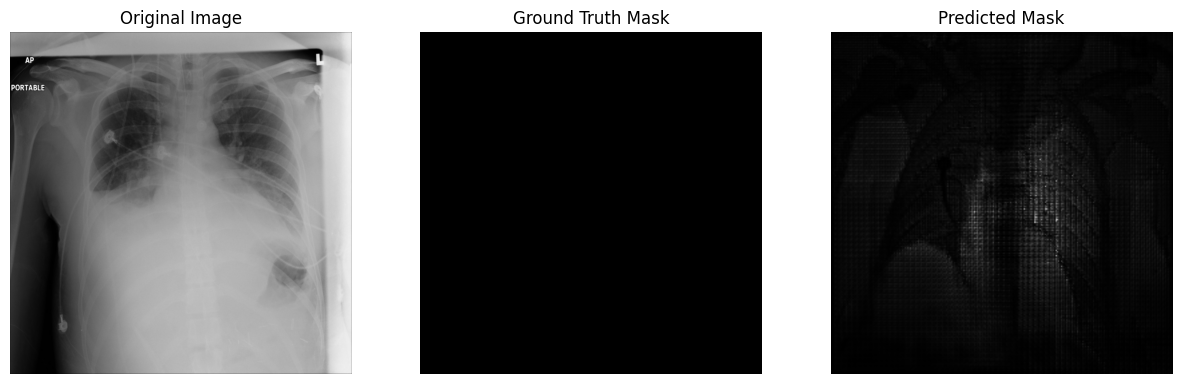

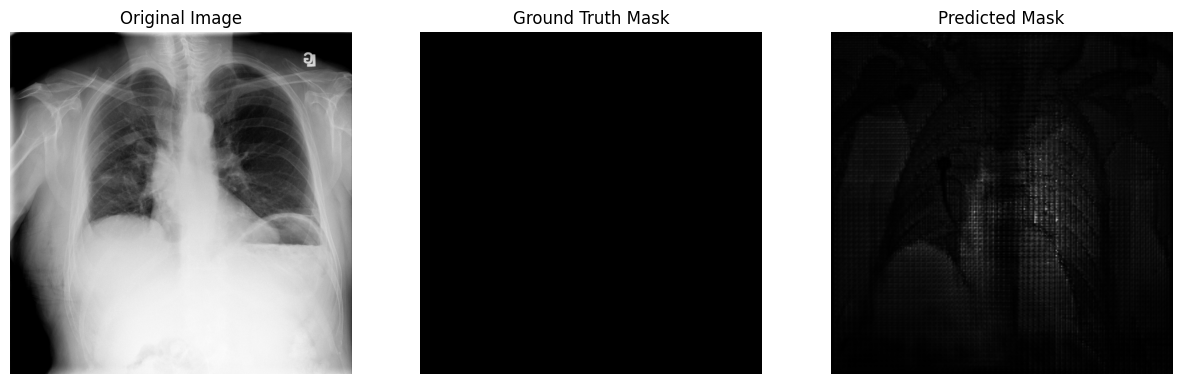

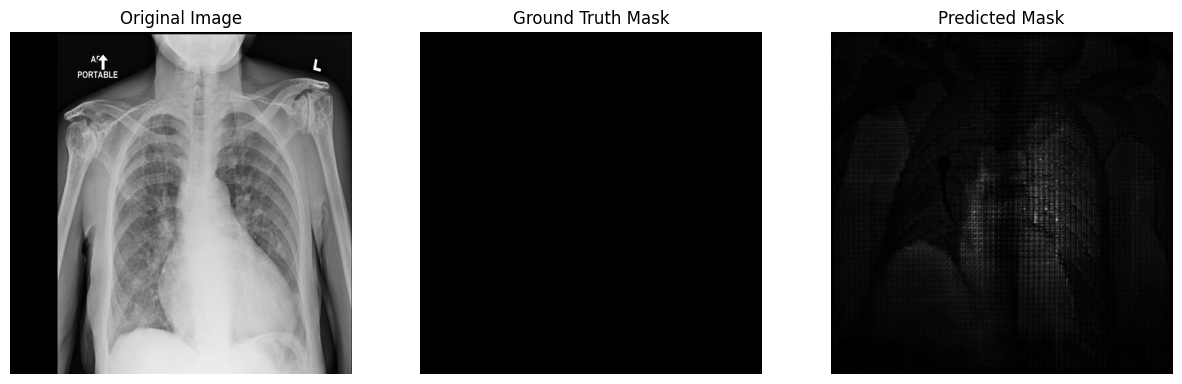

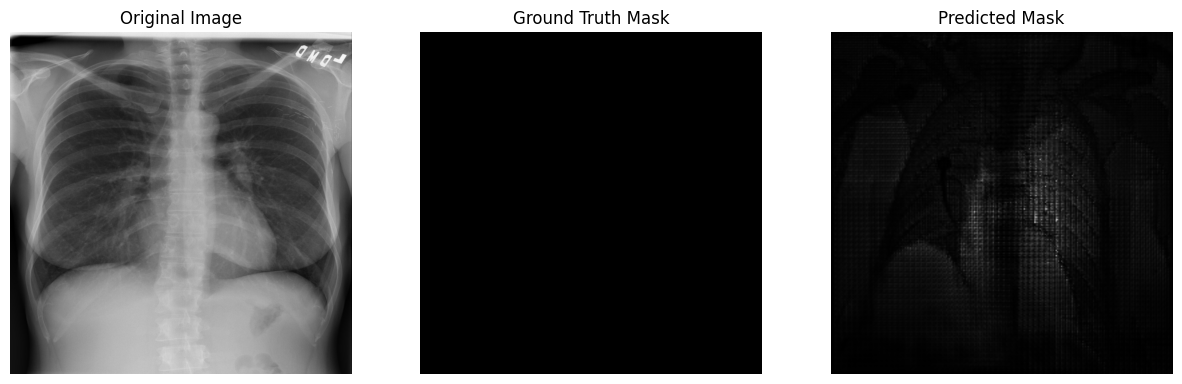

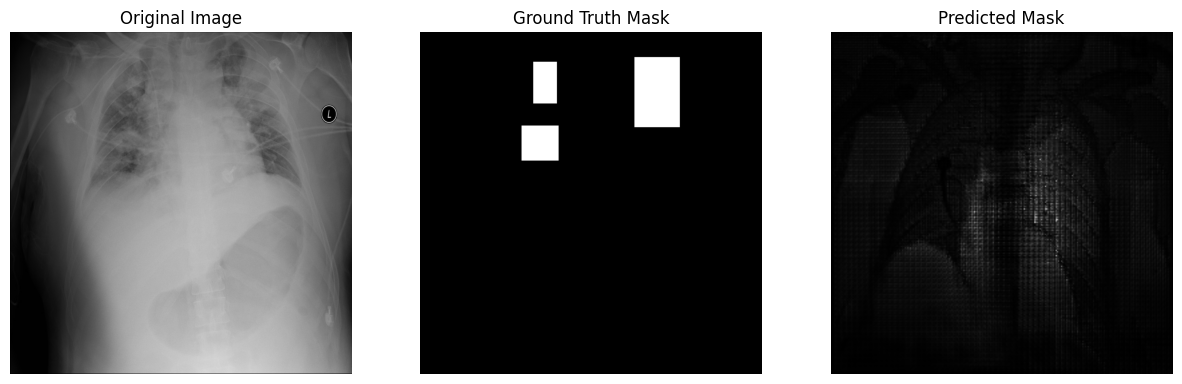

In [27]:
def visualize_prediction(image, mask, predicted_mask):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.show()

#switch to evaluation mode
sam.eval()

#visualize predictions on a few test images
with torch.no_grad():
    for i, (image, mask) in enumerate(dataloader):
        if i >= 5:  #first 5 images
            break
        
        image = image.to(device)
        mask = mask.to(device)
        
        #prepare input for model
        h, w = 1024, 1024
        input_points = torch.tensor([[[w//2, h//2]]], device=device)
        input_labels = torch.tensor([[1]], device=device)

        #forward pass through model
        #generates mask predictions based on input
        image_embeddings = sam.image_encoder(images)
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
            points=(input_points, input_labels),
            boxes=None,
            masks=None,
        )
        
        mask_predictions, _ = sam.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )
        
        mask_predictions = F.interpolate(mask_predictions, size=(1024, 1024), mode='bilinear', align_corners=False)
        
        #apply sigmoid to get probabilities
        predicted_mask = torch.sigmoid(mask_predictions)
        
        #visualize results
        visualize_prediction(image.cpu().squeeze(), mask.cpu().squeeze(), predicted_mask.cpu().squeeze())